In [2]:
import os
import sys
import scanpy as sc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import random
import abc
import os
import scipy.sparse as sp

In [ ]:
work_dir = "/home/yyuan/ICB_TCE/" # Change as need!

script_dir = os.path.join(work_dir, "scripts")
if script_dir not in sys.path:
    sys.path.append(script_dir)

from vae import *
from sde import *
from bio_con import *
from bio_util import *
from training_util import *
from joint_train import *

### Load the original data and select T cells in BRCA

In [ ]:
#adata = sc.read_h5ad(os.path.join(work_dir, 'data/icb.h5ad'))

In [ ]:
#adata_brca = adata[(adata.obs["Cancer_type_update"] == "TNBC") | (adata.obs["Cancer_type_update"] == "HER2+") | (adata.obs["Cancer_type_update"] == "ER+")].copy()

In [ ]:
#adata_brca_t = adata_brca[adata_brca.obs["author_cell_type_update"] == "T_cell"].copy()
#adata_brca_t.write(os.path.join(work_dir, 'data/brca_t_cell.h5ad'))

### Load the data of T cells in BRCA and run pre-process

In [6]:
adata_brca_t = sc.read_h5ad(os.path.join(work_dir, 'data/brca_t_cell.h5ad'))

In [10]:
adata_brca_t.obs["pre_post"].value_counts()

pre_post
Post    37445
Pre     32899
Name: count, dtype: int64

In [3]:
adata_brca_t

AnnData object with n_obs × n_vars = 70344 × 22781
    obs: 'PMID_donor_id', 'donor_id', 'pre_post', 'author_cell_type', 'author_cell_type_update', 'outcome', 'Combined_outcome', 'Cancer_type_update', 'Study_name', 'Primary_or_met', 'donor_id_pre_post', 'donor_id_outcome', 'donor_id_cell_types', 'donor_id_cell_types_pre_post', 'donor_id_pre_post_outcome', 'tissue_ontology_term_id', 'tissue_type', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'PMID', 'Sample', 'Treatment.or.Mode.of.Action', 'suspension_type', 'sex_ontology_term_id', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'nCount_RNA', 'nFeature_RNA', 'Study_name_cancer', 'Cell_type_broad', 'is_primary_data', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'vf_vst_counts_mean', 'vf_vst_counts_variance', 'vf_vst_counts_variance.expected', 'vf_vst_counts_variance.standardized', 'vf

In [ ]:
adata_brca_t.obs['Combined_outcome'].value_counts()

Combined_outcome
Favourable      39053
Unfavourable    25359
n/a              5932
Name: count, dtype: int64

##### Prepare data to use in pySCENIC for GRN inference: 

In [ ]:
## prepare data for pySCENIC
#adata_for_pyscenic = adata_brca_t.copy()
#gene_symbol_column = 'feature_name' 
#pyscenic_input_filename = os.path.join(work_dir, 'data/brca_t_cell_for_pyscenic.csv')

#if gene_symbol_column in adata_for_pyscenic.var.columns:
#    adata_for_pyscenic.var_names = adata_for_pyscenic.var[gene_symbol_column].astype(str)
#    adata_for_pyscenic.var_names_make_unique()
#
#    # Save to CSV
#    adata_for_pyscenic.to_df().to_csv(pyscenic_input_filename)
#
#    print(f"\nSuccessfully created CSV file at: {pyscenic_input_filename}")

We performed pySCENIC through the docker file provided directly by the original authors at https://hub.docker.com/r/aertslab/pyscenic.

In [7]:
# QC and filter highly variable genes
sc.pp.filter_cells(adata_brca_t, min_genes = 200)
sc.pp.filter_genes(adata_brca_t, min_cells = 3)
sc.pp.highly_variable_genes(adata_brca_t, n_top_genes = 3000, subset = True)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### VAE pre-train

In [9]:
# Convert the sparse matrix to a dense numpy array, then to a PyTorch tensor
if hasattr(adata_brca_t.X, "toarray"):
    expression_data = torch.tensor(adata_brca_t.X.toarray(), dtype=torch.float32)
else: # If it's already a dense array
    expression_data = torch.tensor(adata_brca_t.X, dtype=torch.float32)

input_dim = expression_data.shape[1]

In [12]:
# VAE pre-training configuration & preparation
LATENT_DIM = 20
NUM_EPOCHS = 20
BATCH_SIZE = 256
LEARNING_RATE = 1e-4
MODEL_SAVE_PATH = os.path.join(work_dir, "trained_models/vae_pretrain.pth")

# KL Annealing Parameters
KL_START_EPOCH = 3  # Start KL annealing earlier in light pre-training
KL_WARMUP_EPOCHS = 10
    
# Prepare DataLoader
dataset = TensorDataset(expression_data)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

input_dim = expression_data.shape[1]

# Initialize Model and Optimizer
vae = VAE_scRNA(input_dim=input_dim, latent_dim=LATENT_DIM).to(device)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

In [14]:
# VAE pre-training
DO_TRAINING = False

if DO_TRAINING:
    print("Starting VAE pre-training...")
    vae.train()

    for epoch in range(NUM_EPOCHS):
        total_loss = 0
        
        # Calculate beta for KL annealing
        if epoch < KL_START_EPOCH:
            beta = 0.0
        else:
            beta = min(1.0, (epoch - KL_START_EPOCH) / KL_WARMUP_EPOCHS)

        for (batch_features,) in dataloader:
            batch_features = batch_features.to(device)
            
            # Forward pass
            recon_x, mu, log_var = vae(batch_features)
            
            # Compute loss
            loss = elbo_loss(batch_features, recon_x, mu, log_var, beta=beta)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader.dataset)
        scheduler.step(avg_loss)
        
        print(f"Epoch [{epoch+1:03d}/{NUM_EPOCHS}], Beta: {beta:.3f}, Average Loss: {avg_loss:.4f}")
    
    print("\nVAE pre-training complete.")

    torch.save(vae.state_dict(), MODEL_SAVE_PATH)
    print(f"Model saved to {MODEL_SAVE_PATH}\n")
else:
    # Re-create the model instance and load the state dictionary
    vae = load_trained_vae(
        model_path=MODEL_SAVE_PATH,
        input_dim=input_dim,
        latent_dim=LATENT_DIM,
        device=device,
    )
    print(f"Model loaded from {MODEL_SAVE_PATH}")

Model loaded from /home/yyuan/ICB_TCE/trained_models/vae_pretrain.pth


##### Use pre-trained VAE to create embeddings: 

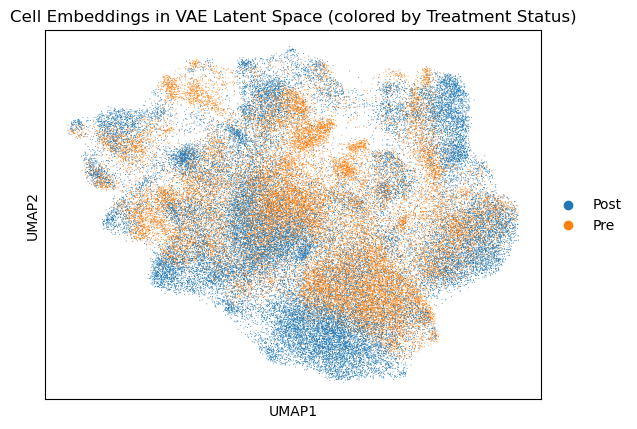

In [15]:
latent_mu = compute_latent_embeddings(vae, expression_data, device=device)
latent_embeddings = latent_mu.numpy()
adata_brca_t.obsm["X_vae"] = latent_embeddings

# UMAP on the VAE latent space
sc.pp.neighbors(adata_brca_t, use_rep='X_vae', n_neighbors=15)
sc.tl.umap(adata_brca_t)
sc.pl.umap(
    adata_brca_t,
    color='pre_post',
    title='Cell Embeddings in VAE Latent Space (colored by Treatment Status)'
)

### Prepare constraint components: 

##### Read GO gene sets from json files: 

In [20]:
cell_death_files = [
    os.path.join(work_dir, "GO_geneset/HALLMARK_APOPTOSIS.v2025.1.Hs.json"),
    os.path.join(work_dir, "GO_geneset/HALLMARK_P53_PATHWAY.v2025.1.Hs.json"),
    os.path.join(work_dir, "GO_geneset/HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY.v2025.1.Hs.json"),
    os.path.join(work_dir, "GO_geneset/HALLMARK_UNFOLDED_PROTEIN_RESPONSE.v2025.1.Hs.json"),
]

cell_birth_files = [
    os.path.join(work_dir, "GO_geneset/HALLMARK_E2F_TARGETS.v2025.1.Hs.json"),
    os.path.join(work_dir, "GO_geneset/HALLMARK_G2M_CHECKPOINT.v2025.1.Hs.json"),
    os.path.join(work_dir, "GO_geneset/HALLMARK_MYC_TARGETS_V1.v2025.1.Hs.json"),
    os.path.join(work_dir, "GO_geneset/HALLMARK_MYC_TARGETS_V2.v2025.1.Hs.json"),
]

all_death_genes = set()
all_birth_genes = set()

print("'Cell Death' Gene Sets:")
for file_path in cell_death_files:
    name, genes = load_gene_set_from_json(file_path)
    if genes:
        all_death_genes.update(genes)

print("\n'Cell Birth' Gene Sets:")
for file_path in cell_birth_files:
    name, genes = load_gene_set_from_json(file_path)
    if genes:
        all_birth_genes.update(genes)

all_death_genes_list = sorted(list(all_death_genes))
all_birth_genes_list = sorted(list(all_birth_genes))

print(f"\nTotal unique 'Cell Death' genes found: {len(all_death_genes_list)}")
print(f"Total unique 'Cell Birth' genes found: {len(all_birth_genes_list)}")

'Cell Death' Gene Sets:
Loaded 161 genes from HALLMARK_APOPTOSIS
Loaded 200 genes from HALLMARK_P53_PATHWAY
Loaded 49 genes from HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY
Loaded 113 genes from HALLMARK_UNFOLDED_PROTEIN_RESPONSE

'Cell Birth' Gene Sets:
Loaded 200 genes from HALLMARK_E2F_TARGETS
Loaded 200 genes from HALLMARK_G2M_CHECKPOINT
Loaded 200 genes from HALLMARK_MYC_TARGETS_V1
Loaded 58 genes from HALLMARK_MYC_TARGETS_V2

Total unique 'Cell Death' genes found: 493
Total unique 'Cell Birth' genes found: 515


In [21]:
# Show some example genes
random.seed(42) 
num_to_sample = 10

# Sample from the 'Cell Death' genes list
if len(all_death_genes_list) >= num_to_sample:
    sampled_death_genes = random.sample(all_death_genes_list, num_to_sample)
else:
    # If there are fewer than num_to_sample genes, take all of them
    sampled_death_genes = all_death_genes_list 

# Sample from the 'Cell Birth' genes list
if len(all_birth_genes_list) >= num_to_sample:
    sampled_birth_genes = random.sample(all_birth_genes_list, num_to_sample)
else:
    # If there are fewer than num_to_sample genes, take all of them
    sampled_birth_genes = all_birth_genes_list


print("Randomly Sampled Genes:")
print(f"\nTotal unique 'Cell Death' genes available for sampling: {len(all_death_genes_list)}")
print(f"Sampled 'Cell Death' genes: {sampled_death_genes}")
print(f"\nTotal unique 'Cell Birth' genes available for sampling: {len(all_birth_genes_list)}")
print(f"Sampled 'Cell Birth' genes: {sampled_birth_genes}")

Randomly Sampled Genes:

Total unique 'Cell Death' genes available for sampling: 493
Sampled 'Cell Death' genes: ['PLK2', 'CAT', 'ANKH', 'RPS12', 'EIF4A2', 'DNAJC3', 'DDIT3', 'CD69', 'RPL18', 'CASP4']

Total unique 'Cell Birth' genes available for sampling: 515
Sampled 'Cell Birth' genes: ['DCK', 'SPC24', 'CBX3', 'CASP8AP2', 'DEK', 'MAPK14', 'MPHOSPH10', 'C1QBP', 'KIF2C', 'SNRPG']


Note: "geneSymbols" in the JSON files matches with the "feature_name" in the AnnData.var matrix

In [22]:
# Constraint preparation using HVG subset
hvg_names_list = adata_brca_t.var['feature_name'].tolist()

# Death genes & their indices within the HVG list
death_genes_in_hvg = [g for g in all_death_genes_list if g in hvg_names_list]
death_gene_indices = [hvg_names_list.index(g) for g in death_genes_in_hvg]
print(f"Found {len(death_gene_indices)} matching cell death genes in the HVG set.")

# Birth genes & their indices within the HVG list
birth_genes_in_hvg = [g for g in all_birth_genes_list if g in hvg_names_list]
birth_gene_indices = [hvg_names_list.index(g) for g in birth_genes_in_hvg]
print(f"Found {len(birth_gene_indices)} matching cell birth genes in the HVG set.")

Found 109 matching cell death genes in the HVG set.
Found 32 matching cell birth genes in the HVG set.


##### Filter GRN with prior knowledge: 

In [ ]:
adj_file = os.path.join(work_dir, "data/brca_t_cell_adj.csv")
prior_edges_file = os.path.join(work_dir, "data/TCE_prior_edges.csv")

grn_df_hvg, grn_data = build_grn_with_prior(
    adj_path=adj_file,
    prior_edges_path=prior_edges_file,
    hvg_names_list=hvg_names_list,
)

plot_grn_elbow(grn_df_hvg, out_path=os.path.join(work_dir, "figures/grn_elbow.png"))

### Joint training: fine-tuning the VAE while training the diffusion Schrödinger Bridge (DSB)

In [27]:
# Prepare for joint training
vae.train()

# Split the latent embeddings into pre/on treatment tensors
pre_treatment_mask = adata_brca_t.obs['pre_post'] == 'Pre'
on_treatment_mask = adata_brca_t.obs['pre_post'] == 'Post'

pre_embeddings = torch.tensor(latent_embeddings[pre_treatment_mask], dtype=torch.float32).to(device)
on_embeddings = torch.tensor(latent_embeddings[on_treatment_mask], dtype=torch.float32).to(device)

print(f"Pre-treatment samples (p): {pre_embeddings.shape}")
print(f"On-treatment samples (q):  {on_embeddings.shape}")

# Data sampler
class DataSampler:
    """
    Data sampler for pre and on-treatment embeddings.
    """
    def __init__(self, data, device):
        self.data = data.to(device)
    def sample(self, batch_size):
        indices = torch.randint(0, len(self.data), (batch_size,))
        return self.data[indices]

# Instantiate the samplers for boundary distributions
p_sampler = DataSampler(pre_embeddings, device=device)
q_sampler = DataSampler(on_embeddings, device=device)

Pre-treatment samples (p): torch.Size([32871, 20])
On-treatment samples (q):  torch.Size([37421, 20])


##### Traing logic of DSB

In a single training step: 

**STEP 1: Sample Trajectories**

Sample starting points from PRE-treatment distribution & Use SDE to propagate forward in time with CURRENT policy

For each timestep t ∈ [0, 1]:

- z_policy = Policy_MLP(x_t, t)      ← Ask policy: "where to go?"

- x_{t+1} = x_t + (drift + diffusion * z_policy) * dt + noise

- Collect trajectory: [x_0, x_1, x_2, ..., x_T]


**STEP 2: Compute Loss**

VAE Loss: L_vae = MSE(original_genes, decoded_genes) + KL(latent)

SB Loss: L_sb

- z_policy_output = Policy_MLP(x_t, t)

- z_optimal = DSB_prediction(x_t, t)  ← Target from Schrödinger Bridge

- W_2 = ||z_policy - z_optimal||²  ← 2-Wasserstein distance

- L_sb = (z_policy · (0.5 * z_policy + z_optimal)) + div(g*z_policy) + W_2

- Biology Loss: L_bio = GRN_penalty + Death_penalty + Birth_penalty


**STEP 3: Backpropagate & Update**

- Gradient flows: L_total → Policy_MLP weights

- Policy learns: "My current velocity was wrong, adjust it"

- Next iteration: Policy outputs better velocities

In [28]:
# Configuration
config = {
    # SDE settings
    "sde_type": "ve",
    "sigma_min": 0.01,
    "sigma_max": 50,
    "T": 1.0,
    "interval": 100,
    "t0": 1e-2,
    
    # Training settings
    "num_stages": 5,
    "num_epochs": 10,
    "num_itr": 500,
    "samp_bs": 1024,      # Trajectory sampling batch size (# of sampled trajectories)
    "train_bs_x": 256,    # Training batch size for x samples (# of cells per gradient update)
    "train_bs_t": 64,     # Batch size for time indices (# of time steps sampled per iteration)
    "lr": 2e-4,
    
    # Data settings
    "data_dim": [LATENT_DIM], # Use the LATENT_DIM variable from VAE training
    
    # Loss component weights
    # L_total = lambda_vae * L_vae + lambda_sb * L_sb + lambda_bio * L_bio
    "lambda_vae": 1.0,     # VAE REFINED during joint training (equal weight with SB!)
    "lambda_sb": 1.0,      # Main SB objective with 2-Wasserstein distance
    "lambda_bio": 0.5,     # Biology constraints (moderate: guide but don't overpower)

    # Biological Constraint Weights applied within L_bio component
    "lambda_grn": 0.1,     # GRN regulatory relationships
    "lambda_death": 0.5,   # Cell death gene expression
    "lambda_birth": 0.5,   # Cell proliferation gene expression
}

In [ ]:
# Initialize Dynamics and Policies
dyn = VESDE(config, p_sampler, q_sampler)
ts = torch.linspace(config['t0'], config['T'], config['interval']).to(device)

net_f = MLP(input_dim=config['data_dim'][0], output_dim=config['data_dim'][0]).to(device)
net_b = MLP(input_dim=config['data_dim'][0], output_dim=config['data_dim'][0]).to(device)

z_f = SchrodingerBridgePolicy(config, 'forward', dyn, net_f)
z_b = SchrodingerBridgePolicy(config, 'backward', dyn, net_b)

optimizer_f = torch.optim.Adam(z_f.parameters(), lr=config['lr'])
optimizer_b = torch.optim.Adam(z_b.parameters(), lr=config['lr'])

# Initialize optimizer for VAE (joint training)
optimizer_vae = torch.optim.Adam(vae.parameters(), lr=1e-4)

# Get the VAE decoder's output layer for decoding latent states to gene space
vae_decoder = lambda z: vae.decoder_output(vae.decoder(z))

In [ ]:
# Main Joint Training Loop
DO_TRAINING = False

if DO_TRAINING:
    print(f"\n{'='*70}")
    print("JOINT TRAINING: VAE + Schrödinger Bridge + Biological Constraints")
    print(f"{'='*70}")
    print(f"Loss components: L_total = λ_vae*L_vae + λ_sb*L_sb + λ_bio*L_bio")
    print(f"  λ_vae={config['lambda_vae']}, λ_sb={config['lambda_sb']}, λ_bio={config['lambda_bio']}\n")

    training_history = run_joint_training_loop(
        config=config,
        dyn=dyn,
        ts=ts,
        vae=vae,
        vae_decoder=vae_decoder,
        z_f=z_f,
        z_b=z_b,
        optimizer_f=optimizer_f,
        optimizer_b=optimizer_b,
        optimizer_vae=optimizer_vae,
        expression_data=expression_data,
        grn_data=grn_data,
        death_gene_indices=death_gene_indices,
        birth_gene_indices=birth_gene_indices,
        device=device,
    )

    print(f"\n{'='*70}")
    print("Joint training complete.")
    print(f"{'='*70}\n")


JOINT TRAINING: VAE + Schrödinger Bridge + Biological Constraints
Loss components: L_total = λ_vae*L_vae + λ_sb*L_sb + λ_bio*L_bio
  λ_vae=1.0, λ_sb=1.0, λ_bio=0.5


STAGE 1/5

  [Backward Policy Training]
    Epoch  1/10: total=35.1710, vae=3.7877, dsb=7.5197, bio=47.7271
    Epoch  2/10: total=3.5838, vae=1.0947, dsb=2.4469, bio=0.0845
    Epoch  3/10: total=3.1799, vae=1.0913, dsb=2.0725, bio=0.0321
    Epoch  4/10: total=3.0284, vae=1.0898, dsb=1.9302, bio=0.0169
    Epoch  5/10: total=2.8980, vae=1.0885, dsb=1.8044, bio=0.0100


KeyboardInterrupt: 

In [ ]:
# Save trained models
MODEL_DIR = "./trained_models"
save_trained_models(
    model_dir=MODEL_DIR,
    config=config,
    dyn=dyn,
    vae=vae,
    z_f=z_f,
    z_b=z_b,
    training_history=training_history,
    input_dim=input_dim,
    latent_dim=LATENT_DIM,
)

In [ ]:
# Load trained models
model_dict = load_trained_models(
    model_dir="./trained_models",
    device=device,
    VAEClass=VAE_scRNA,
    policy_mlp_cls=MLP,
    sde_cls=VESDE,
)


LOADING TRAINED MODELS

- Config loaded
  Data dim: [20]
  Latent dim: 20
  Num stages: 5
- VAE loaded
  Input dim: 3000
  Latent dim: 20
- SDE dynamics reconstructed
- Time steps reconstructed
  Shape: torch.Size([100]), Range: [0.0100, 1.0000]
- Forward policy loaded
- Backward policy loaded
- Training history loaded

- All models loaded successfully.

Ready to use:
  ts shape: torch.Size([100])
  ts device: cuda:0


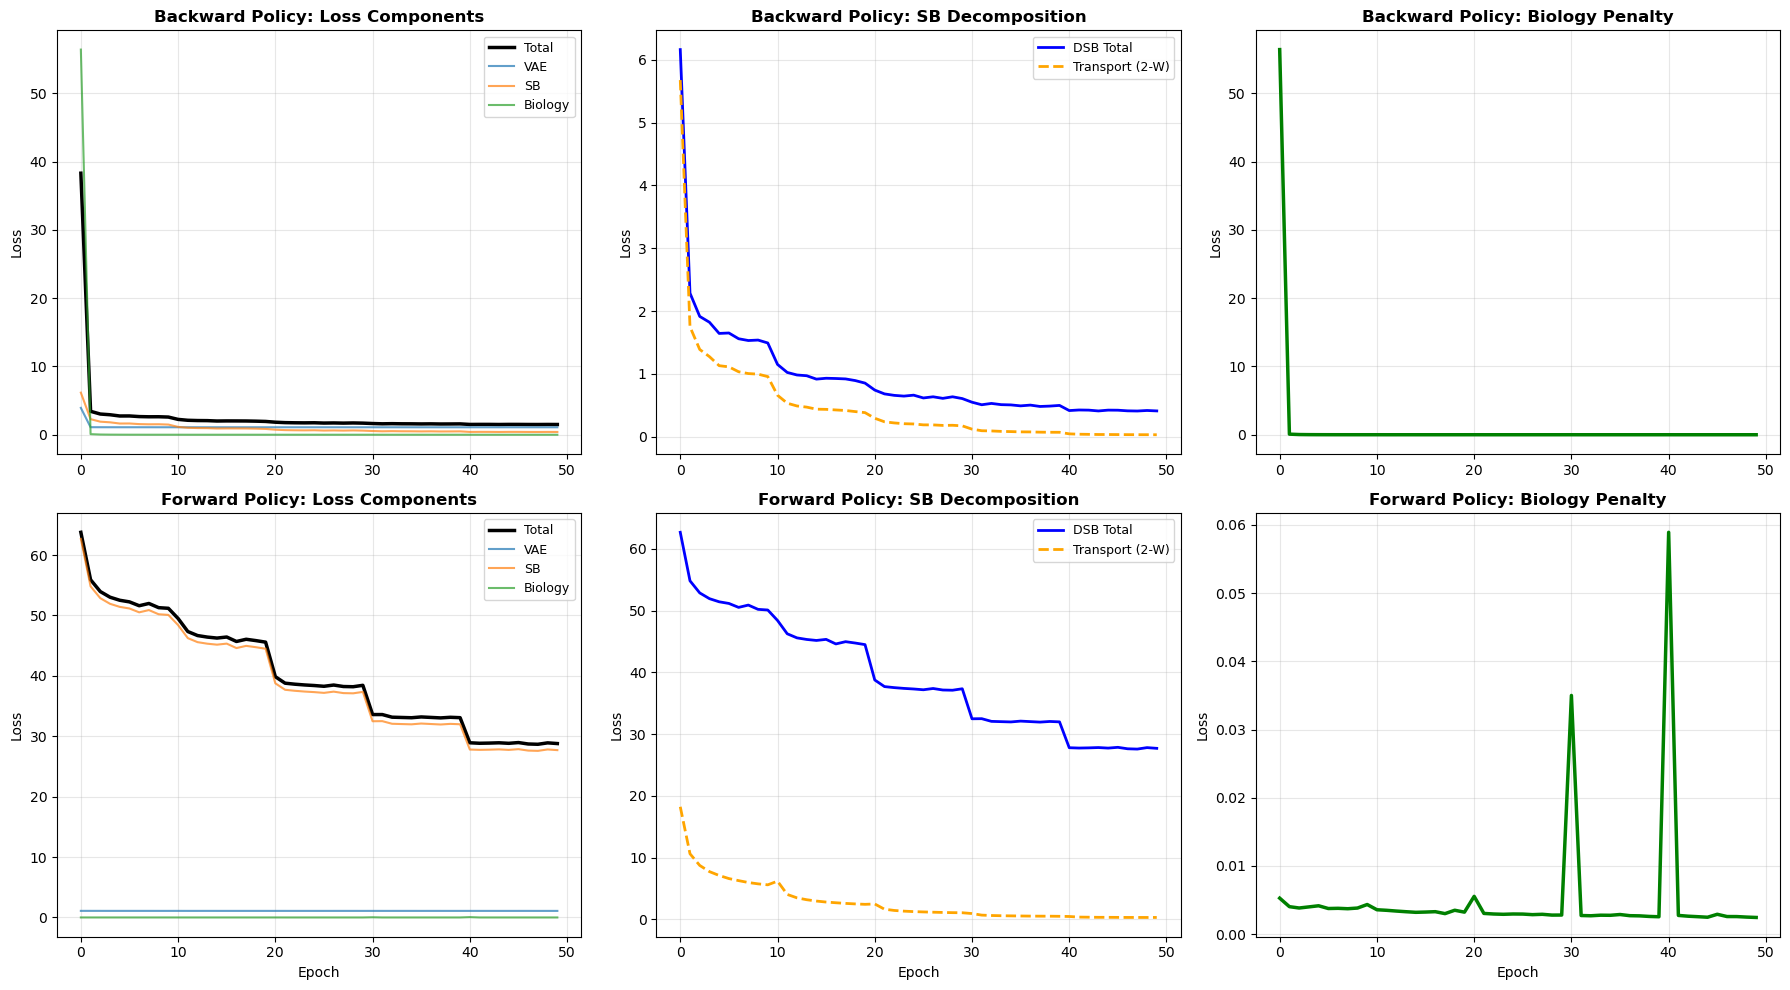


TRAINING SUMMARY - All Components

Backward Policy (pre → on):
  Final total loss:       1.5021
  Final VAE loss:         1.0928
  Final SB loss:          0.4087
  Final Transport loss:   0.0292
  Final Biology loss:     0.0011

Forward Policy (on → pre):
  Final total loss:      28.7905
  Final VAE loss:         1.0893
  Final SB loss:         27.6999
  Final Transport loss:   0.3310
  Final Biology loss:     0.0025

Training history visualization saved to './joint_training_history.png'


In [ ]:
# Visualize Joint Training History - All Components (using util.py)
plot_joint_training_history(training_history, out_path=os.path.join(work_dir, "figures/joint_training_history.png"))
print_training_summary(training_history)

##### Drift Calculation Method:
$$\text{Gene Drift} = \frac{\text{VAE}(\mathbf{z} + \epsilon \cdot \mathbf{v}(t)) - \text{VAE}(\mathbf{z})}{\epsilon}$$

where:
- $\mathbf{v}(t)$ is the policy network output (learned velocity)
- $\epsilon$ is a small perturbation ($10^{-4}$)
- Averaged across all cells in each treatment group



DRIFT GENE ANALYSIS - Calculating drift genes from policy networks
Treatment column: pre_post
Pre-treatment value: Pre
On-treatment value: Post

Cells - Pre: 32871, On-treatment: 37421
Expression data shapes - Pre: torch.Size([32871, 3000]), On: torch.Size([37421, 3000])
Latent embeddings - Pre: torch.Size([32871, 20]), On: torch.Size([37421, 20])

[Forward Process] Pre → On-treatment
[Backward Process] On-treatment → Pre

✓ CSV files saved: drift_genes_forward.csv, drift_genes_backward.csv

Top 20 Forward Drift Genes:
        gene  drift_velocity  abs_drift  is_death_gene  is_birth_gene
2080   RPS26        0.235084   0.235084          False          False
704     CD74        0.229385   0.229385          False          False
2288  S100A4       -0.182646   0.182646           True          False
2053  NFKBIA        0.163200   0.163200          False          False
2287  S100A6       -0.143383   0.143383          False          False
428    COTL1        0.142516   0.142516          False

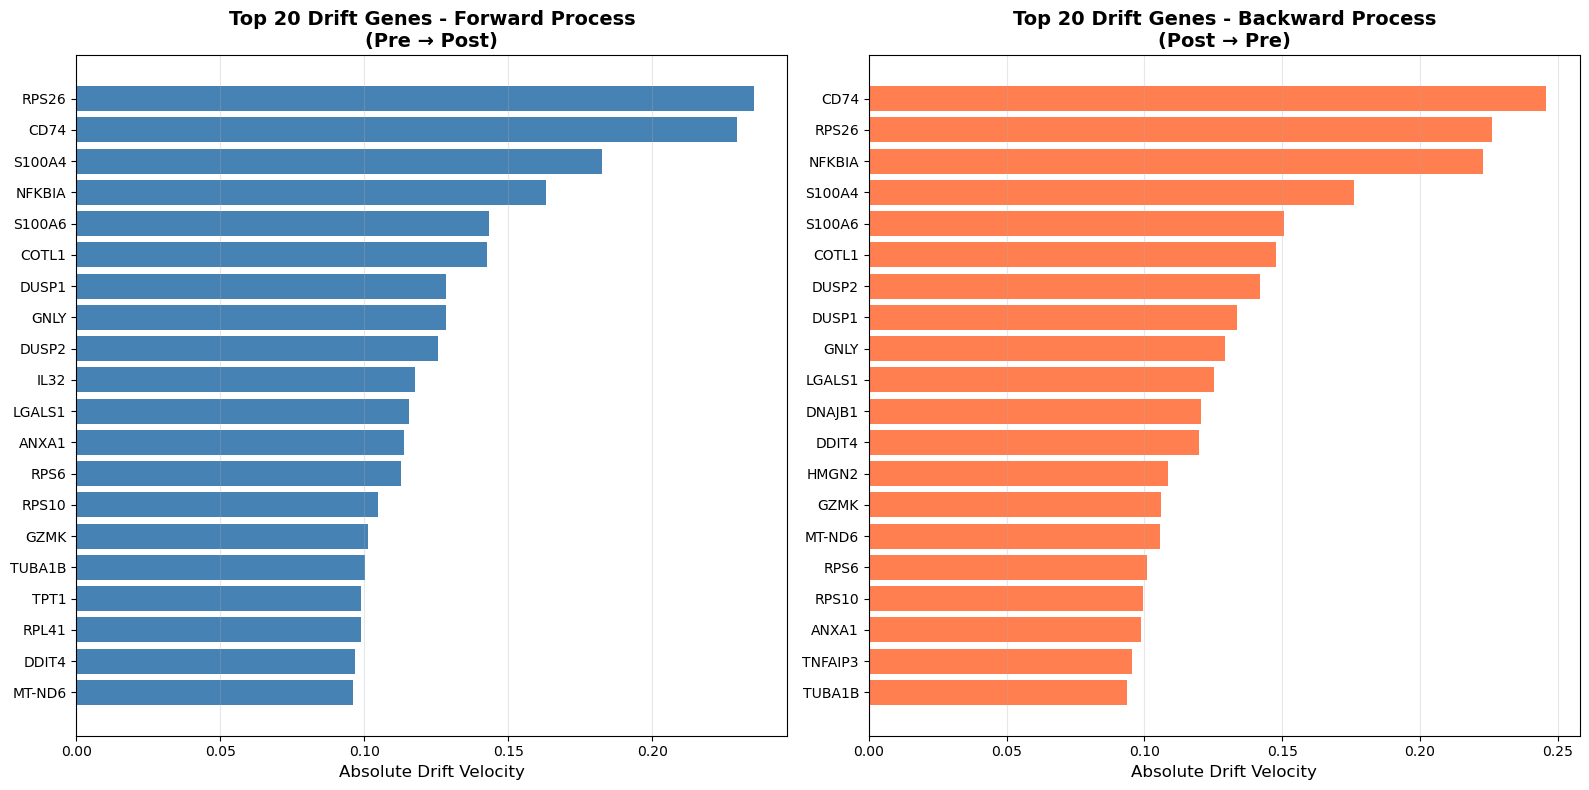


SUMMARY STATISTICS
Forward drift - Mean |velocity| (top 20): 0.131709
Backward drift - Mean |velocity| (top 20): 0.137440

Common genes in top 20: 17
  ANXA1, CD74, COTL1, DDIT4, DUSP1, DUSP2, GNLY, GZMK, LGALS1, MT-ND6, NFKBIA, RPS10, RPS26, RPS6, S100A4, S100A6, TUBA1B

Death/Birth genes in top 50 (Forward): 6 death, 5 birth
Death/Birth genes in top 50 (Backward): 6 death, 5 birth


In [ ]:
# Drift Gene Analysis
print("\n" + "="*80)
print("DRIFT GENE ANALYSIS - Calculating drift genes from policy networks")
print("="*80)

# Obtain treatment column name and values
treatment_col = [col for col in adata_brca_t.obs.columns if 'treatment' in col.lower() or 'pre' in col.lower()][0]
unique_vals = adata_brca_t.obs[treatment_col].unique()
pre_val = [v for v in unique_vals if 'pre' in str(v).lower() or v == 0][0]
on_val = [v for v in unique_vals if 'pre' not in str(v).lower() and v != 0][0]

print(f"Treatment column: {treatment_col}")
print(f"Pre-treatment value: {pre_val}")
print(f"On-treatment value: {on_val}")

# Get masks
pre_mask = adata_brca_t.obs[treatment_col] == pre_val
on_treatment_mask = adata_brca_t.obs[treatment_col] == on_val

print(f"\nCells - Pre: {pre_mask.sum()}, On-treatment: {on_treatment_mask.sum()}")

# Load expression data
pre_cells_expr = adata_brca_t[pre_mask].X
if sp.issparse(pre_cells_expr):
    pre_cells_expr = pre_cells_expr.toarray()
pre_cells_expr = torch.tensor(pre_cells_expr, dtype=torch.float32)

on_cells_expr = adata_brca_t[on_treatment_mask].X
if sp.issparse(on_cells_expr):
    on_cells_expr = on_cells_expr.toarray()
on_cells_expr = torch.tensor(on_cells_expr, dtype=torch.float32)

print(f"Expression data shapes - Pre: {pre_cells_expr.shape}, On: {on_cells_expr.shape}")

gene_symbols = adata_brca_t.var["feature_name"].values.tolist()

forward_drift_df, backward_drift_df = compute_drift_tables(
    vae=vae,
    z_f=z_f,
    z_b=z_b,
    pre_cells_expr=pre_cells_expr,
    on_cells_expr=on_cells_expr,
    gene_symbols=gene_symbols,
    epsilon=1e-4,
)

# Add biological annotations
death_genes = set(all_death_genes_list) if "all_death_genes_list" in dir() else set()
birth_genes = set(all_birth_genes_list) if "all_birth_genes_list" in dir() else set()

forward_drift_df["is_death_gene"] = forward_drift_df["gene"].isin(death_genes)
forward_drift_df["is_birth_gene"] = forward_drift_df["gene"].isin(birth_genes)
backward_drift_df["is_death_gene"] = backward_drift_df["gene"].isin(death_genes)
backward_drift_df["is_birth_gene"] = backward_drift_df["gene"].isin(birth_genes)

forward_drift_df.to_csv("drift_genes_forward.csv", index=False)
backward_drift_df.to_csv("drift_genes_backward.csv", index=False)

top20_forward = forward_drift_df.head(20)
top20_backward = backward_drift_df.head(20)

# Plot and save into work_dir/figures with dpi=300
fig_dir = os.path.join(work_dir, "figures")
os.makedirs(fig_dir, exist_ok=True)
plot_top_drift_genes(
    forward_drift_df,
    backward_drift_df,
    k=20,
    out_path=os.path.join(fig_dir, "top20_drift_genes.png"),
)

# Summary statistics
print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)
print(f"Forward drift - Mean |velocity| (top 20): {top20_forward['abs_drift'].mean():.6f}")
print(f"Backward drift - Mean |velocity| (top 20): {top20_backward['abs_drift'].mean():.6f}")

common_genes = set(top20_forward['gene']) & set(top20_backward['gene'])
print(f"\nCommon genes in top 20: {len(common_genes)}")
if common_genes:
    print(f"  {', '.join(sorted(common_genes))}")

# Biological gene statistics
top50_fw = forward_drift_df.head(50)
top50_bw = backward_drift_df.head(50)

print(f"\nDeath/Birth genes in top 50 (Forward): {top50_fw['is_death_gene'].sum()} death, {top50_fw['is_birth_gene'].sum()} birth")
print(f"Death/Birth genes in top 50 (Backward): {top50_bw['is_death_gene'].sum()} death, {top50_bw['is_birth_gene'].sum()} birth")

print("=" * 80)

## Gradient Flow and Biological Interpretation

```
Observed Cells (x_obs) [70k × 3000]
    ↓
VAE Encoder → Latent (z) [20D]
    ↓
    ├─→ L_vae encourages VAE to stay calibrated
    │       ↓
    │   Gene reconstruction must match distribution
    │
    └─→ Policy Network (z_t → velocity) [20D → 20D]
            ↓
            ├─→ [L_sb = DSB + W_2^2] Learn trajectory following uDSB
            │       ↓
            │   Follow optimal transport from pre→on
            │
            └─→ VAE Decoder: velocity → gene changes [20D → 3000D]
                    ↓
                    ├─→ [L_grn] Respect TF→target relationships
                    ├─→ [L_death] Keep death genes LOW (cells survive)
                    └─→ [L_birth] Keep birth genes LOW (cells stop dividing)
```

---

# Joint Training: Latent Dynamics + Gene-Space Biology Constraints

## High-Level Idea

We train a VAE + Schrodinger Bridge (SB) jointly:

- The **VAE** learns a low-dimensional latent representation $z$ of gene expression $x$.
- The **SB policies** learn forward / backward latent dynamics $z_t \mapsto v_\theta(z_t, t)$ between pre- and on-treatment distributions.
- All **biological constraints** are applied **after decoding back to gene space** $\hat x = \text{Decoder}(z)$, because we only know the biology (GRN, death / birth genes) in expression space.

At each iteration we optimize a weighted sum of three losses:

$$L_{\text{total}} = \lambda_{\text{vae}} L_{\text{vae}} + \lambda_{\text{sb}} L_{\text{sb}} + \lambda_{\text{bio}} L_{\text{bio}}.$$

---

## 1. VAE Loss $L_{\text{vae}}$ (Reconstruction + KL)

For a minibatch of observed gene expressions $x_{\text{orig}}$:

1. Encode: $(\mu, \log \sigma^2) = q_\phi(z \mid x_{\text{orig}})$.
2. Sample latent: $z \sim \mathcal{N}(\mu, \sigma^2 I)$.
3. Decode to gene space: $\hat x = \text{Decoder}(z)$ (with nonnegative activation like Softplus).

The loss used in joint training is:

$$L_{\text{vae}} = \operatorname{MSE}(x_{\text{orig}}, \hat x) + \beta \cdot \operatorname{KL}\big(q_\phi(z \mid x_{\text{orig}}) \Vert p(z)\big).$$

- **Role:** keep the decoder calibrated to real gene expression while SB and biology losses update the latents.
- **Where:** implemented in `VAE_scRNA` and `compute_vae_loss` in `vae.py`, called from `compute_loss_with_all_components` in `joint_train.py`.

---

## 2. SB Loss $L_{\text{sb}}$ (DSB Matching + Velocity Consistency)

In latent space, the SB policies output velocities $v_\theta(z_t, t)$ that should match the optimal dynamics between pre- and on-treatment distributions. The implementation follows the "unbiased DSB" formulation with two pieces:

- **DSB matching term** (divergence + inner product with optimal velocity).
- **Velocity consistency term** encouraging agreement between the current policy and an importance-sampled optimal velocity.

For a minibatch of states $z_t$, importance-sampled velocities $v_{\text{impt}}$, and times $t$:

$$L_{\text{sb}} = \mathbb{E}\big[ v_\theta \cdot (0.5\, v_\theta + v_{\text{impt}}) + \operatorname{div}(g(t) v_\theta) \big] \cdot \Delta t + \mathbb{E}\big[\lVert v_\theta - v_{\text{impt}} \rVert^2\big].$$

- **Role:** align the learned policies with the Schr
odinger Bridge dynamics and stabilize training.
- **Where:** `compute_dsb_loss_with_velocity_consistency` and `compute_div_gz` in `sde.py`, used inside `compute_loss_with_all_components`.

---

## 3. Biology Loss $L_{\text{bio}}$ (in Gene Expression Space Only)

Biological priors live in gene space, not in latent space. We therefore:

1. Run the latent SDE policy to get latent states $z_t$ and $z_{t+\Delta t}$.
2. Decode them to predicted gene expressions $\hat x_t = \text{Decoder}(z_t)$ and $\hat x_{t+\Delta t} = \text{Decoder}(z_{t+\Delta t})$.
3. Apply biology constraints **only on** $(\hat x_t, \hat x_{t+\Delta t})$.

The biology loss decomposes as:

$$L_{\text{bio}} = \lambda_{\text{grn}} L_{\text{grn}} + \lambda_{\text{death}} L_{\text{death}} + \lambda_{\text{birth}} L_{\text{birth}},$$

with different terms active in each direction:

- **Backward policy (pre $\rightarrow$ on)**
  - $L_{\text{grn}}$: GRN consistency on decoded **next-step** expression $\hat x_{t+\Delta t}$.
  - $L_{\text{death}}$: penalty on decoded **current** expression $\hat x_t$ if death genes are highly expressed.
- **Forward policy (on $\rightarrow$ pre)**
  - $L_{\text{grn}}$: GRN consistency on decoded **current** expression $\hat x_t$.
  - $L_{\text{birth}}$: penalty on decoded **next-step** expression $\hat x_{t+\Delta t}$ if birth genes are highly expressed.

The concrete forms are:

- **GRN penalty** (`compute_grn_penalty` in `bio_con.py`):

  $$L_{\text{grn}} = \mathbb{E}\Big[\sum_i w_i (\text{target}_i - \text{TF}_i)^2\Big],$$

  where $(\text{TF}_i, \text{target}_i, w_i)$ come from the pySCENIC-derived GRN restricted to HVGs.

- **Cell-fate penalties** (`compute_cell_fate_score` + directional wrappers in `bio_con.py`):

  - Backward: $L_{\text{death}} = \operatorname{ReLU}(\mathbb{E}[\text{death-gene expression at step } t])$.
  - Forward: $L_{\text{birth}} = \operatorname{ReLU}(\mathbb{E}[\text{birth-gene expression at step } t+\Delta t])$.

All of these operate **only on decoded gene expression** tensors.

---

## 4. Putting It Together in Code

Joint training is orchestrated by `run_joint_training_loop` in `joint_train.py`:

- Alternates between **backward** (pre $\rightarrow$ on) and **forward** (on $\rightarrow$ pre) policy updates over several stages.
- For each direction and epoch:
  - Samples latent trajectories from the SDE (`dyn.sample_traj` in `sde.py`).
  - Builds minibatches of $(z_t, z_{t+\Delta t}, t)$ and importance-sampled velocities.
  - Encodes a minibatch of real gene expression to compute $(\mu, \log \sigma^2)$ for the VAE loss.
  - Decodes both VAE latents and SDE latents to gene space.
  - Calls `compute_loss_with_all_components` to compute and backpropagate $L_{\text{total}}$.

Key configuration weights live in `config` (see the nearby code cell):

- `lambda_vae`: weight on $L_{\text{vae}}$ (typically 1.0).
- `lambda_sb`: weight on $L_{\text{sb}}$ (typically 1.0).
- `lambda_bio`: global weight on $L_{\text{bio}}$ (e.g. 0.5).
- `lambda_grn`, `lambda_death`, `lambda_birth`: internal weights for biology sub-terms.

This reflects the **current, modular implementation**: latent SB dynamics + VAE calibration, with all biological structure enforced after decoding into gene expression space.

## Visual Summary: Latent Dynamics + Gene-Space Biology

```text
┌───────────────────────────────────────────────────────────────────────┐
│                 Joint Training: Latent SB + Gene Biology            │
└───────────────────────────────────────────────────────────────────────┘

            Observed gene expression x (cells × genes)
                               │
                               ▼
                   ┌────────────────────────┐
                   │      VAE Encoder      │  qϕ(z | x)
                   └──────────┬────────────┘
                              │  latent z
                              ▼
                    ┌────────────────────┐
                    │   Latent SDE +    │
                    │  SB Policies vθ   │
                    └────────┬──────────┘
                             │ z_t, z_{t+Δt}
                             ▼
                  ┌──────────────────────────┐
                  │      VAE Decoder        │  x̂ = Decoder(z)
                  └────────┬────────────────┘
                           │ decoded gene expression
                           ▼
          ┌────────────────────────────────────────────────────┐
          │ Losses                                            │
          ├────────────────────────────────────────────────────┤
          │ L_vae : VAE reconstruction + KL (in gene space)   │
          │ L_sb  : DSB matching + velocity consistency (z,t) │
          │ L_bio : GRN + death / birth in gene space only    │
          └────────────────────────────────────────────────────┘

    L_total = λ_vae · L_vae  +  λ_sb · L_sb  +  λ_bio · L_bio
```

### Where Each Loss Lives

- **Latent space (z, t)**
  - $L_{\text{sb}}$: divergence + inner product + velocity consistency.

- **Gene space ($x$, $\hat x$)**
  - $L_{\text{vae}}$: match decoded $\hat x$ to observed $x$.
  - $L_{\text{bio}}$: apply GRN and cell-fate penalties on decoded $\hat x_t$, $\hat x_{t+\Delta t}$.

This separation is exactly what the code does: optimize SB dynamics in latent space, but enforce biological structure only after decoding into gene expression space.

In [ ]:
# ABLATION STUDY: Training WITHOUT Biology Constraints
RUN_ABLATION = False

if RUN_ABLATION:
    print("\n" + "="*70)
    print("ABLATION: Training WITHOUT Biology Constraints")
    print("="*70)

    # Create a separate config for ablation so original config is untouched
    config_abl = config.copy()
    config_abl['input_dim'] = expression_data.shape[1]
    
    # Disable all biology constraints in ablation only
    config_abl['lambda_bio'] = 0.0
    config_abl['lambda_grn'] = 0.0
    config_abl['lambda_death'] = 0.0
    config_abl['lambda_birth'] = 0.0
    
    print(f"\nLoss Config (No Bio / Ablation):")
    print(f"  λ_vae = {config_abl['lambda_vae']}")
    print(f"  λ_sb = {config_abl['lambda_sb']}")
    print(f"  λ_bio = {config_abl['lambda_bio']} (DISABLED)")
    print(f"  λ_grn = {config_abl['lambda_grn']} (DISABLED)")
    print(f"  λ_death = {config_abl['lambda_death']} (DISABLED)")
    print(f"  λ_birth = {config_abl['lambda_birth']} (DISABLED)")
    print("="*70 + "\n")
    
    vae_abl = VAE_scRNA(
        input_dim=config_abl["input_dim"],
        latent_dim=config_abl["data_dim"][0],
    ).to(device)
    vae_abl.load_state_dict(torch.load("./trained_models/vae_pretrain.pth", map_location=device))
    print("Loaded pre-trained VAE from ./trained_models/vae_pretrain.pth\n")

    z_f_abl = SchrodingerBridgePolicy(
        config_abl, "forward", dyn, MLP(config_abl["data_dim"][0], config_abl["data_dim"][0])
    ).to(device)
    z_b_abl = SchrodingerBridgePolicy(
        config_abl, "backward", dyn, MLP(config_abl["data_dim"][0], config_abl["data_dim"][0])
    ).to(device)

    optimizer_vae_abl = torch.optim.Adam(vae_abl.parameters(), lr=config_abl["lr"], weight_decay=1e-4)
    optimizer_f_abl = torch.optim.Adam(z_f_abl.parameters(), lr=config_abl["lr"], weight_decay=1e-4)
    optimizer_b_abl = torch.optim.Adam(z_b_abl.parameters(), lr=config_abl["lr"], weight_decay=1e-4)

    vae_decoder_abl = lambda z: vae_abl.decoder_output(vae_abl.decoder(z))
    
    # Joint training loop (ablation)
    ablation_history = run_joint_training_loop(
        config=config_abl,
        dyn=dyn,
        ts=ts,
        vae=vae_abl,
        vae_decoder=vae_decoder_abl,
        z_f=z_f_abl,
        z_b=z_b_abl,
        optimizer_f=optimizer_f_abl,
        optimizer_b=optimizer_b_abl,
        optimizer_vae=optimizer_vae_abl,
        expression_data=expression_data,
        grn_data=grn_data,
        death_gene_indices=death_gene_indices,
        birth_gene_indices=birth_gene_indices,
        device=device,
)

    print(f"\n{'='*70}")
    print("Ablation training complete. Saving results to ./ablation/")
    print(f"{'='*70}\n")
    
    os.makedirs('./ablation', exist_ok=True)
    
    with open('./ablation/ablation_history.json', 'w') as f:
        json.dump(ablation_history, f, indent=2)
    
    # Save only state_dicts here (no config fields attached)
    torch.save(vae_abl.state_dict(), './ablation/vae_ablation.pth')
    torch.save(z_f_abl.state_dict(), './ablation/z_f_ablation.pth')
    torch.save(z_b_abl.state_dict(), './ablation/z_b_ablation.pth')
    
    print("Ablation models and history saved.")


ABLATION: Training WITHOUT Biology Constraints

Loss Config (No Bio):
  λ_vae = 1.0
  λ_sb = 1.0
  λ_bio = 0.0 (DISABLED)
  λ_grn = 0.0 (DISABLED)
  λ_death = 0.0 (DISABLED)
  λ_birth = 0.0 (DISABLED)

Loaded pre-trained VAE from ./trained_models/vae_pretrain.pth

Training with NO BIOLOGY constraints (λ_bio=0)...


JOINT TRAINING: VAE + Schrödinger Bridge (NO Biology Constraints)
Loss components: L_total = λ_vae*L_vae + λ_sb*L_sb + λ_bio*L_bio
  λ_vae=1.0, λ_sb=1.0, λ_bio=0.0


ABLATION STAGE 1/5

  [Backward Policy Training]
    Epoch  1/10: total=6.8086, vae=1.0896, dsb=5.7189, bio=0.0000
    Epoch  2/10: total=3.3320, vae=1.0890, dsb=2.2430, bio=0.0000
    Epoch  3/10: total=2.9995, vae=1.0897, dsb=1.9097, bio=0.0000
    Epoch  4/10: total=2.7525, vae=1.0887, dsb=1.6638, bio=0.0000
    Epoch  5/10: total=2.7256, vae=1.0893, dsb=1.6363, bio=0.0000
    Epoch  6/10: total=2.6663, vae=1.0885, dsb=1.5778, bio=0.0000
    Epoch  7/10: total=2.5821, vae=1.0891, dsb=1.4931, bio=0.0000
    E

#### Original vs Ablation Comparison

We compare:
- **Original joint model**: trained with all three loss terms ($L_{\text{vae}}$, $L_{\text{sb}}$, $L_{\text{bio}}$).
- **Ablation model**: trained with the same architecture and schedule but **biology disabled** ($\lambda_{\text{bio}} = 0$ and all biology sub-weights set to 0).

The next cells:
1. Load both sets of checkpoints and their training histories.
2. Plot training curves (total, VAE, SB) for original vs ablation.
3. Recompute drift-gene tables using `compute_drift_tables` for both models.
4. Visualize / summarize how biology constraints change drift genes.


In [ ]:
# Load histories
with open('./trained_models/training_history.json', 'r') as f:
    training_history = json.load(f)
with open('./ablation/ablation_history.json', 'r') as f:
    ablation_history = json.load(f)

# ----- Original joint-trained models -----
vae_orig_ckpt = torch.load('./trained_models/vae_joint_trained.pth', map_location=device)
vae_orig = VAE_scRNA(
    input_dim=vae_orig_ckpt['input_dim'],
    latent_dim=vae_orig_ckpt['latent_dim'],
).to(device)
vae_orig.load_state_dict(vae_orig_ckpt['model_state_dict'])

z_f_orig_ckpt = torch.load('./trained_models/z_f_policy.pth', map_location=device)
z_f_orig = SchrodingerBridgePolicy(
    config, 'forward', dyn, MLP(config['data_dim'][0], config['data_dim'][0])
).to(device)
z_f_orig.net.load_state_dict(z_f_orig_ckpt['model_state_dict'])

z_b_orig_ckpt = torch.load('./trained_models/z_b_policy.pth', map_location=device)
z_b_orig = SchrodingerBridgePolicy(
    config, 'backward', dyn, MLP(config['data_dim'][0], config['data_dim'][0])
).to(device)
z_b_orig.net.load_state_dict(z_b_orig_ckpt['model_state_dict'])

# ----- Ablation models -----
# VAE ablation: same input_dim as pretraining, same latent dim as config
vae_abl_state = torch.load('./ablation/vae_ablation.pth', map_location=device)
vae_abl = VAE_scRNA(
    input_dim=expression_data.shape[1],
    latent_dim=config['data_dim'][0],
).to(device)
vae_abl.load_state_dict(vae_abl_state)

# Forward policy (ablation)
z_f_abl_state = torch.load('./ablation/z_f_ablation.pth', map_location=device)
z_f_abl = SchrodingerBridgePolicy(
    config, 'forward', dyn, MLP(config['data_dim'][0], config['data_dim'][0])
).to(device)
z_f_abl.load_state_dict(z_f_abl_state)

# Backward policy (ablation)
z_b_abl_state = torch.load('./ablation/z_b_ablation.pth', map_location=device)
z_b_abl = SchrodingerBridgePolicy(
    config, 'backward', dyn, MLP(config['data_dim'][0], config['data_dim'][0])
).to(device)
z_b_abl.load_state_dict(z_b_abl_state)

<All keys matched successfully>


ABLATION STUDY: Training Comparison (Original vs No Biology Constraints)


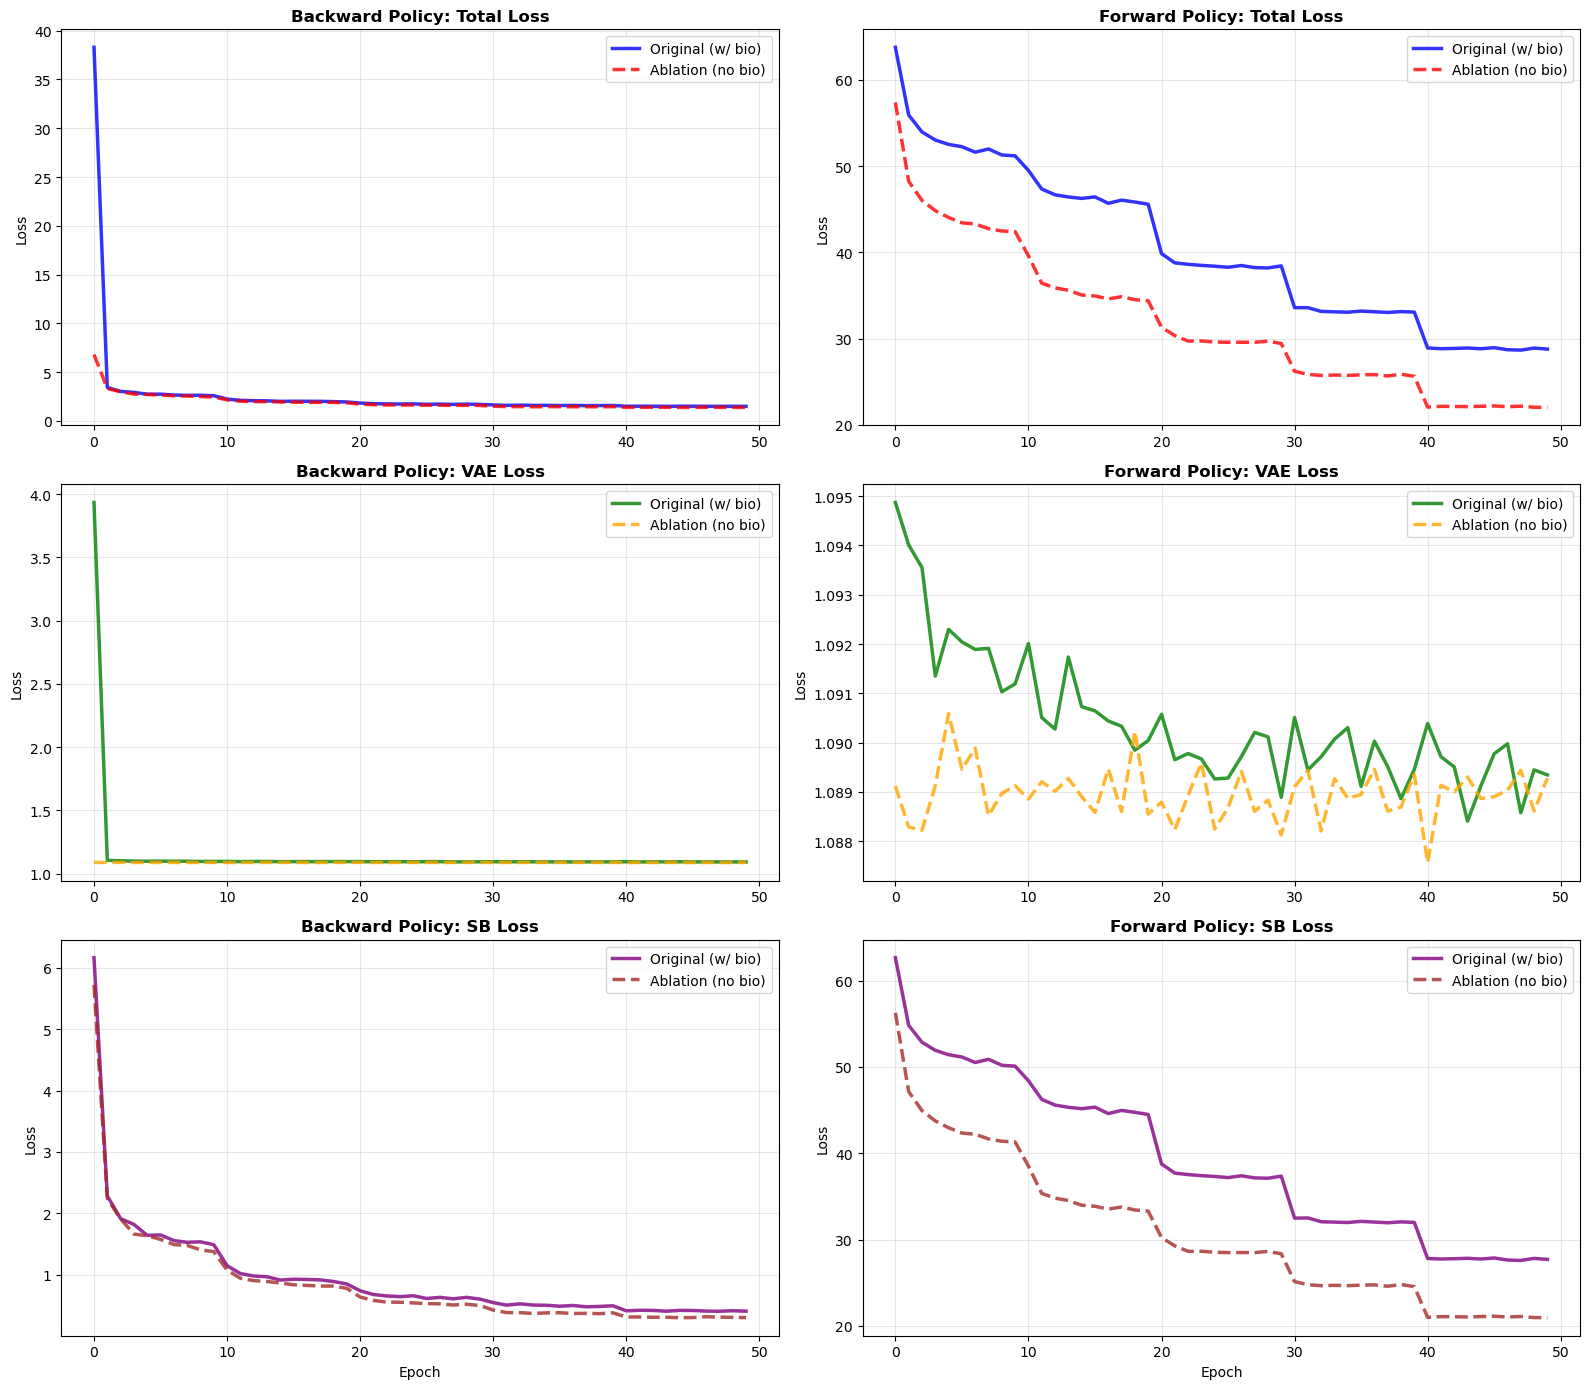


TRAINING SUMMARY COMPARISON

Backward Policy (pre → on):
  Metric                    Original        Ablation        Difference     
  ----------------------------------------------------------------------
  Final total loss                  1.5021         1.3921        -0.1100
  Final VAE loss                    1.0928         1.0885        -0.0043
  Final SB loss                     0.4087         0.3035        -0.1052

Forward Policy (on → pre):
  Metric                    Original        Ablation        Difference     
  ----------------------------------------------------------------------
  Final total loss                 28.7905        22.0313        -6.7591
  Final VAE loss                    1.0893         1.0893        -0.0001
  Final SB loss                    27.6999        20.9420        -6.7578

Visualization saved to './ablation/training_history_comparison.png'


In [ ]:
# Visualize Comparative Training History - Original vs Ablation Study
if ablation_history is not None:
    print("\n" + "="*80)
    print("ABLATION STUDY: Training Comparison (Original vs No Biology Constraints)")
    print("="*80)
    
    fig, axes = plt.subplots(3, 2, figsize=(16, 14))
    
    # Row 1: Total Loss Comparison
    # Backward policy total loss
    axes[0, 0].plot(training_history['b_loss_total'], label='Original (w/ bio)', linewidth=2.5, color='blue', alpha=0.8)
    axes[0, 0].plot(ablation_history['b_loss_total'], label='Ablation (no bio)', linewidth=2.5, color='red', linestyle='--', alpha=0.8)
    axes[0, 0].set_title('Backward Policy: Total Loss', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Forward policy total loss
    axes[0, 1].plot(training_history['f_loss_total'], label='Original (w/ bio)', linewidth=2.5, color='blue', alpha=0.8)
    axes[0, 1].plot(ablation_history['f_loss_total'], label='Ablation (no bio)', linewidth=2.5, color='red', linestyle='--', alpha=0.8)
    axes[0, 1].set_title('Forward Policy: Total Loss', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Row 2: VAE Loss Comparison
    axes[1, 0].plot(training_history['b_loss_vae'], label='Original (w/ bio)', linewidth=2.5, color='green', alpha=0.8)
    axes[1, 0].plot(ablation_history['b_loss_vae'], label='Ablation (no bio)', linewidth=2.5, color='orange', linestyle='--', alpha=0.8)
    axes[1, 0].set_title('Backward Policy: VAE Loss', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].plot(training_history['f_loss_vae'], label='Original (w/ bio)', linewidth=2.5, color='green', alpha=0.8)
    axes[1, 1].plot(ablation_history['f_loss_vae'], label='Ablation (no bio)', linewidth=2.5, color='orange', linestyle='--', alpha=0.8)
    axes[1, 1].set_title('Forward Policy: VAE Loss', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)
    
    # Row 3: SB Loss Comparison
    axes[2, 0].plot(training_history['b_loss_dsb'], label='Original (w/ bio)', linewidth=2.5, color='purple', alpha=0.8)
    axes[2, 0].plot(ablation_history['b_loss_dsb'], label='Ablation (no bio)', linewidth=2.5, color='brown', linestyle='--', alpha=0.8)
    axes[2, 0].set_title('Backward Policy: SB Loss', fontsize=12, fontweight='bold')
    axes[2, 0].set_ylabel('Loss')
    axes[2, 0].set_xlabel('Epoch')
    axes[2, 0].legend(fontsize=10)
    axes[2, 0].grid(True, alpha=0.3)
    
    axes[2, 1].plot(training_history['f_loss_dsb'], label='Original (w/ bio)', linewidth=2.5, color='purple', alpha=0.8)
    axes[2, 1].plot(ablation_history['f_loss_dsb'], label='Ablation (no bio)', linewidth=2.5, color='brown', linestyle='--', alpha=0.8)
    axes[2, 1].set_title('Forward Policy: SB Loss', fontsize=12, fontweight='bold')
    axes[2, 1].set_ylabel('Loss')
    axes[2, 1].set_xlabel('Epoch')
    axes[2, 1].legend(fontsize=10)
    axes[2, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('./ablation/training_history_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("TRAINING SUMMARY COMPARISON")
    print("="*80)
    
    print(f"\nBackward Policy (pre → on):")
    print(f"  {'Metric':<25} {'Original':<15} {'Ablation':<15} {'Difference':<15}")
    print(f"  {'-'*70}")
    orig_b_total = training_history['b_loss_total'][-1]
    abl_b_total = ablation_history['b_loss_total'][-1]
    print(f"  {'Final total loss':<25} {orig_b_total:>14.4f} {abl_b_total:>14.4f} {abl_b_total - orig_b_total:>14.4f}")
    
    orig_b_vae = training_history['b_loss_vae'][-1]
    abl_b_vae = ablation_history['b_loss_vae'][-1]
    print(f"  {'Final VAE loss':<25} {orig_b_vae:>14.4f} {abl_b_vae:>14.4f} {abl_b_vae - orig_b_vae:>14.4f}")
    
    orig_b_dsb = training_history['b_loss_dsb'][-1]
    abl_b_dsb = ablation_history['b_loss_dsb'][-1]
    print(f"  {'Final SB loss':<25} {orig_b_dsb:>14.4f} {abl_b_dsb:>14.4f} {abl_b_dsb - orig_b_dsb:>14.4f}")
    
    print(f"\nForward Policy (on → pre):")
    print(f"  {'Metric':<25} {'Original':<15} {'Ablation':<15} {'Difference':<15}")
    print(f"  {'-'*70}")
    orig_f_total = training_history['f_loss_total'][-1]
    abl_f_total = ablation_history['f_loss_total'][-1]
    print(f"  {'Final total loss':<25} {orig_f_total:>14.4f} {abl_f_total:>14.4f} {abl_f_total - orig_f_total:>14.4f}")
    
    orig_f_vae = training_history['f_loss_vae'][-1]
    abl_f_vae = ablation_history['f_loss_vae'][-1]
    print(f"  {'Final VAE loss':<25} {orig_f_vae:>14.4f} {abl_f_vae:>14.4f} {abl_f_vae - orig_f_vae:>14.4f}")
    
    orig_f_dsb = training_history['f_loss_dsb'][-1]
    abl_f_dsb = ablation_history['f_loss_dsb'][-1]
    print(f"  {'Final SB loss':<25} {orig_f_dsb:>14.4f} {abl_f_dsb:>14.4f} {abl_f_dsb - orig_f_dsb:>14.4f}")
    
    print("\n" + "="*80)
    print("Visualization saved to './ablation/training_history_comparison.png'")
    print("="*80)


In [ ]:
# Drift Gene Analysis - Ablation Study
# Compare drift genes between original model and ablation model

if ablation_history is not None:
    print("\n" + "="*80)
    print("DRIFT GENE ANALYSIS: Original Model vs Ablation Study (No Biology Constraints)")
    print("="*80)
    
    # Treatment info
    treatment_col = [col for col in adata_brca_t.obs.columns
                     if 'treatment' in col.lower() or 'pre' in col.lower()][0]
    unique_vals = adata_brca_t.obs[treatment_col].unique()
    pre_val = [v for v in unique_vals if 'pre' in str(v).lower() or v == 0][0]
    on_val = [v for v in unique_vals if 'pre' not in str(v).lower() and v != 0][0]
    
    pre_mask = adata_brca_t.obs[treatment_col] == pre_val
    on_treatment_mask = adata_brca_t.obs[treatment_col] == on_val
    
    pre_cells_expr = adata_brca_t[pre_mask].X
    if sp.issparse(pre_cells_expr):
        pre_cells_expr = pre_cells_expr.toarray()
    pre_cells_expr = torch.tensor(pre_cells_expr, dtype=torch.float32)

    on_cells_expr = adata_brca_t[on_treatment_mask].X
    if sp.issparse(on_cells_expr):
        on_cells_expr = on_cells_expr.toarray()
    on_cells_expr = torch.tensor(on_cells_expr, dtype=torch.float32)

    gene_symbols = adata_brca_t.var['feature_name'].values.tolist()
    epsilon = 1e-4

    # ===== ORIGINAL MODEL DRIFT =====
    print("\n[Original Model] Computing drift genes...")
    forward_drift_df_orig, backward_drift_df_orig = compute_drift_tables(
        vae=vae_orig,
        z_f=z_f_orig,
        z_b=z_b_orig,
        pre_cells_expr=pre_cells_expr,
        on_cells_expr=on_cells_expr,
        gene_symbols=gene_symbols,
        epsilon=epsilon,
    )

    # ===== ABLATION MODEL DRIFT =====
    print("[Ablation Model] Computing drift genes...")
    forward_drift_df_abl, backward_drift_df_abl = compute_drift_tables(
        vae=vae_abl,
        z_f=z_f_abl,
        z_b=z_b_abl,
        pre_cells_expr=pre_cells_expr,
        on_cells_expr=on_cells_expr,
        gene_symbols=gene_symbols,
        epsilon=epsilon,
    )

    # Save CSVs
    os.makedirs('./ablation', exist_ok=True)
    forward_drift_df_orig.to_csv('./ablation/drift_genes_forward_original.csv', index=False)
    backward_drift_df_orig.to_csv('./ablation/drift_genes_backward_original.csv', index=False)
    forward_drift_df_abl.to_csv('./ablation/drift_genes_forward_ablation.csv', index=False)
    backward_drift_df_abl.to_csv('./ablation/drift_genes_backward_ablation.csv', index=False)
    print("✓ CSV files saved to ./ablation/")

    # Biological annotations (optional, as in your version)
    death_genes = set(all_death_genes_list) if 'all_death_genes_list' in dir() else set()
    birth_genes = set(all_birth_genes_list) if 'all_birth_genes_list' in dir() else set()
    for df in [forward_drift_df_orig, backward_drift_df_orig,
               forward_drift_df_abl, backward_drift_df_abl]:
        df['is_death_gene'] = df['gene'].isin(death_genes)
        df['is_birth_gene'] = df['gene'].isin(birth_genes)

    # Top-20 tables (same as before)
    top20_forward_orig = forward_drift_df_orig.head(20)
    top20_backward_orig = backward_drift_df_orig.head(20)
    top20_forward_abl = forward_drift_df_abl.head(20)
    top20_backward_abl = backward_drift_df_abl.head(20)

    print("\n[Original Model] Top 20 Forward Drift Genes (Pre → Post):")
    print(top20_forward_orig[['gene', 'drift_velocity', 'abs_drift']].to_string())

    print("\n[Ablation Model] Top 20 Forward Drift Genes (Pre → Post):")
    print(top20_forward_abl[['gene', 'drift_velocity', 'abs_drift']].to_string())

    print("\n[Original Model] Top 20 Backward Drift Genes (Post → Pre):")
    print(top20_backward_orig[['gene', 'drift_velocity', 'abs_drift']].to_string())

    print("\n[Ablation Model] Top 20 Backward Drift Genes (Post → Pre):")
    print(top20_backward_abl[['gene', 'drift_velocity', 'abs_drift']].to_string())
else:
    print("Drift gene ablation analysis skipped: run ablation training and reload histories first.")


DRIFT GENE ANALYSIS: Original Model vs Ablation Study (No Biology Constraints)

[Original Model] Computing drift genes...
[Ablation Model] Computing drift genes...
✓ CSV files saved to ./ablation/

[Original Model] Top 20 Forward Drift Genes (Pre → Post):
         gene  drift_velocity  abs_drift
1091  MT-ATP8        0.134224   0.134224
1044    DUSP2       -0.128716   0.128716
2288   S100A4       -0.122391   0.122391
913      GNLY       -0.117398   0.117398
1577   IFITM2       -0.097268   0.097268
1096   MT-ND4        0.094352   0.094352
1092  MT-ATP6        0.091528   0.091528
1305   LGALS1       -0.086487   0.086487
2920    TXNIP        0.080985   0.080985
2858  TNFAIP3       -0.079126   0.079126
972      CD8A        0.077937   0.077937
971      CD8B        0.072277   0.072277
1763    HMGN2        0.069033   0.069033
2053   NFKBIA       -0.067937   0.067937
826    GIMAP7        0.067124   0.067124
1095  MT-ND4L        0.061163   0.061163
428     COTL1        0.061096   0.061096
1094 


DRIFT GENE VISUALIZATION - Original vs Ablation Study


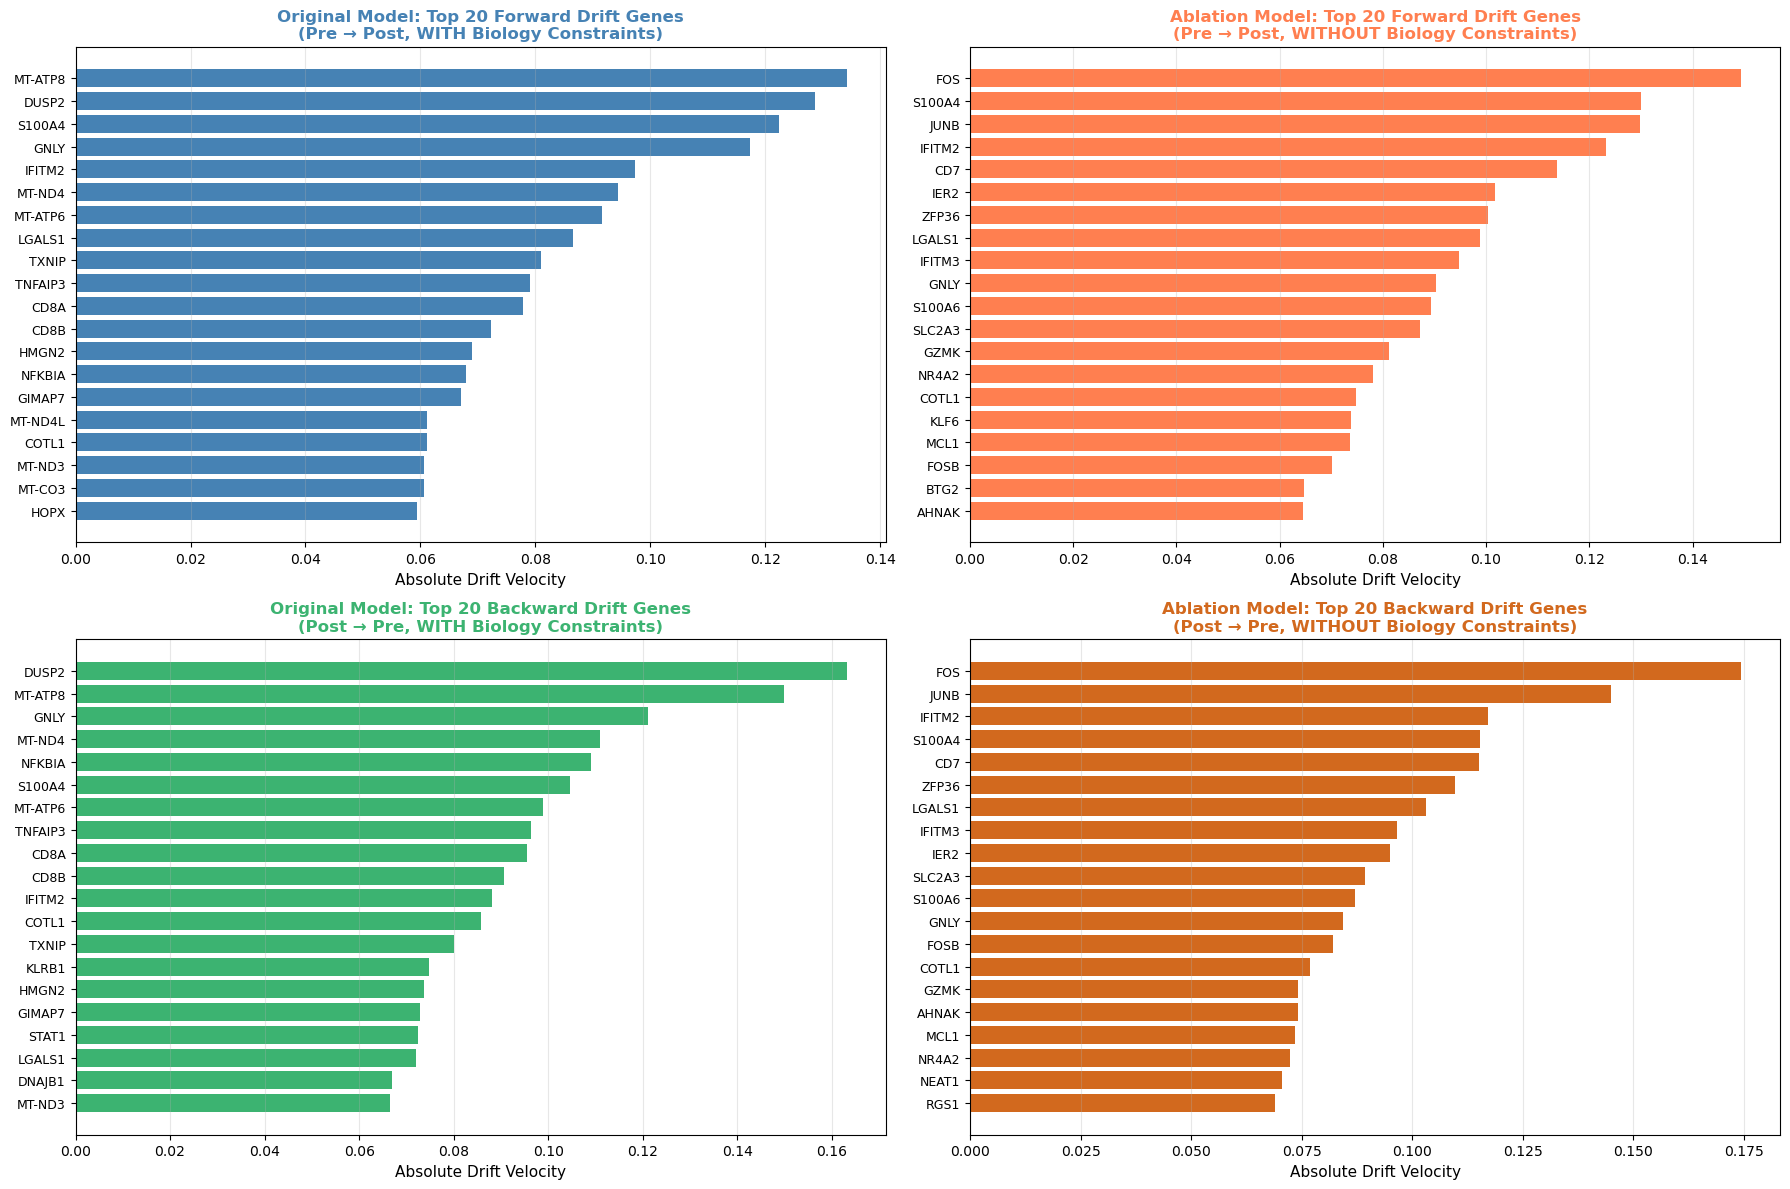

✓ Visualization saved to './ablation/drift_genes_comparison.png'


In [37]:
# Visualize Drift Gene Comparison: Original vs Ablation

# Require: drift-analysis cell above has run and defined:
#   top20_forward_orig, top20_forward_abl,
#   top20_backward_orig, top20_backward_abl
if (
    ablation_history is not None
    and 'top20_forward_orig' in dir()
    and 'top20_forward_abl' in dir()
    and 'top20_backward_orig' in dir()
    and 'top20_backward_abl' in dir()
):
    print("\n" + "="*80)
    print("DRIFT GENE VISUALIZATION - Original vs Ablation Study")
    print("="*80)

    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # ===== FORWARD PROCESS: Pre → Post =====
    # Original Model - Forward
    axes[0, 0].barh(range(20), top20_forward_orig['abs_drift'].values, color='steelblue')
    axes[0, 0].set_yticks(range(20))
    axes[0, 0].set_yticklabels(top20_forward_orig['gene'].values, fontsize=9)
    axes[0, 0].set_xlabel('Absolute Drift Velocity', fontsize=11)
    axes[0, 0].set_title(
        'Original Model: Top 20 Forward Drift Genes\n(Pre → Post, WITH Biology Constraints)',
        fontsize=12, fontweight='bold', color='steelblue'
    )
    axes[0, 0].invert_yaxis()
    axes[0, 0].grid(axis='x', alpha=0.3)

    # Ablation Model - Forward
    axes[0, 1].barh(range(20), top20_forward_abl['abs_drift'].values, color='coral')
    axes[0, 1].set_yticks(range(20))
    axes[0, 1].set_yticklabels(top20_forward_abl['gene'].values, fontsize=9)
    axes[0, 1].set_xlabel('Absolute Drift Velocity', fontsize=11)
    axes[0, 1].set_title(
        'Ablation Model: Top 20 Forward Drift Genes\n(Pre → Post, WITHOUT Biology Constraints)',
        fontsize=12, fontweight='bold', color='coral'
    )
    axes[0, 1].invert_yaxis()
    axes[0, 1].grid(axis='x', alpha=0.3)

    # ===== BACKWARD PROCESS: Post → Pre =====
    # Original Model - Backward
    axes[1, 0].barh(range(20), top20_backward_orig['abs_drift'].values, color='mediumseagreen')
    axes[1, 0].set_yticks(range(20))
    axes[1, 0].set_yticklabels(top20_backward_orig['gene'].values, fontsize=9)
    axes[1, 0].set_xlabel('Absolute Drift Velocity', fontsize=11)
    axes[1, 0].set_title(
        'Original Model: Top 20 Backward Drift Genes\n(Post → Pre, WITH Biology Constraints)',
        fontsize=12, fontweight='bold', color='mediumseagreen'
    )
    axes[1, 0].invert_yaxis()
    axes[1, 0].grid(axis='x', alpha=0.3)

    # Ablation Model - Backward
    axes[1, 1].barh(range(20), top20_backward_abl['abs_drift'].values, color='chocolate')
    axes[1, 1].set_yticks(range(20))
    axes[1, 1].set_yticklabels(top20_backward_abl['gene'].values, fontsize=9)
    axes[1, 1].set_xlabel('Absolute Drift Velocity', fontsize=11)
    axes[1, 1].set_title(
        'Ablation Model: Top 20 Backward Drift Genes\n(Post → Pre, WITHOUT Biology Constraints)',
        fontsize=12, fontweight='bold', color='chocolate'
    )
    axes[1, 1].invert_yaxis()
    axes[1, 1].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig('./ablation/drift_genes_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ Visualization saved to './ablation/drift_genes_comparison.png'")
else:
    print("Drift comparison visualization skipped: run the drift analysis cell first.")

In [38]:
# Statistical Analysis: Compare Drift Genes between Original and Ablation

if ablation_history is not None and 'forward_drift_df_orig' in dir():
    print("\n" + "="*80)
    print("STATISTICAL COMPARISON: Drift Gene Analysis")
    print("="*80)
    
    # ===== FORWARD PROCESS ANALYSIS =====
    print("\n[FORWARD PROCESS] Pre → Post Treatment:")
    print("-" * 80)
    
    # Top 50 for detailed analysis
    top50_forward_orig = forward_drift_df_orig.head(50)
    top50_forward_abl = forward_drift_df_abl.head(50)
    
    # Common genes in top 50
    common_forward = set(top50_forward_orig['gene']) & set(top50_forward_abl['gene'])
    print(f"\nOriginal model - Mean |drift| (top 50): {top50_forward_orig['abs_drift'].mean():.6f}")
    print(f"Ablation model - Mean |drift| (top 50): {top50_forward_abl['abs_drift'].mean():.6f}")
    print(f"Overlap in top 50 drift genes: {len(common_forward)} genes")
    if common_forward:
        print(f"  Common genes: {', '.join(sorted(list(common_forward)[:10]))}...")
    
    # Biological gene statistics
    orig_death_fw = top50_forward_orig['is_death_gene'].sum()
    orig_birth_fw = top50_forward_orig['is_birth_gene'].sum()
    abl_death_fw = top50_forward_abl['is_death_gene'].sum()
    abl_birth_fw = top50_forward_abl['is_birth_gene'].sum()
    
    print(f"\nBiological genes in top 50:")
    print(f"  Original - Death genes: {orig_death_fw}, Birth genes: {orig_birth_fw}")
    print(f"  Ablation - Death genes: {abl_death_fw}, Birth genes: {abl_birth_fw}")
    
    # Rank correlation
    forward_orig_ranked = {gene: rank for rank, gene in enumerate(top50_forward_orig['gene'])}
    forward_abl_ranked = {gene: rank for rank, gene in enumerate(top50_forward_abl['gene'])}
    
    common_with_ranks = [(gene, forward_orig_ranked.get(gene, 50), forward_abl_ranked.get(gene, 50)) 
                         for gene in common_forward]
    rank_diffs_fw = [abs(r1 - r2) for _, r1, r2 in common_with_ranks]
    
    if rank_diffs_fw:
        print(f"\nRank correlation (for common genes in top 50):")
        print(f"  Mean rank difference: {np.mean(rank_diffs_fw):.2f}")
        print(f"  Median rank difference: {np.median(rank_diffs_fw):.2f}")
    
    # ===== BACKWARD PROCESS ANALYSIS =====
    print("\n" + "-"*80)
    print("[BACKWARD PROCESS] Post → Pre Treatment:")
    print("-" * 80)
    
    top50_backward_orig = backward_drift_df_orig.head(50)
    top50_backward_abl = backward_drift_df_abl.head(50)
    
    # Common genes in top 50
    common_backward = set(top50_backward_orig['gene']) & set(top50_backward_abl['gene'])
    print(f"\nOriginal model - Mean |drift| (top 50): {top50_backward_orig['abs_drift'].mean():.6f}")
    print(f"Ablation model - Mean |drift| (top 50): {top50_backward_abl['abs_drift'].mean():.6f}")
    print(f"Overlap in top 50 drift genes: {len(common_backward)} genes")
    if common_backward:
        print(f"  Common genes: {', '.join(sorted(list(common_backward)[:10]))}...")
    
    # Biological gene statistics
    orig_death_bw = top50_backward_orig['is_death_gene'].sum()
    orig_birth_bw = top50_backward_orig['is_birth_gene'].sum()
    abl_death_bw = top50_backward_abl['is_death_gene'].sum()
    abl_birth_bw = top50_backward_abl['is_birth_gene'].sum()
    
    print(f"\nBiological genes in top 50:")
    print(f"  Original - Death genes: {orig_death_bw}, Birth genes: {orig_birth_bw}")
    print(f"  Ablation - Death genes: {abl_death_bw}, Birth genes: {abl_birth_bw}")
    
    # Rank correlation
    backward_orig_ranked = {gene: rank for rank, gene in enumerate(top50_backward_orig['gene'])}
    backward_abl_ranked = {gene: rank for rank, gene in enumerate(top50_backward_abl['gene'])}
    
    common_with_ranks_bw = [(gene, backward_orig_ranked.get(gene, 50), backward_abl_ranked.get(gene, 50)) 
                            for gene in common_backward]
    rank_diffs_bw = [abs(r1 - r2) for _, r1, r2 in common_with_ranks_bw]
    
    if rank_diffs_bw:
        print(f"\nRank correlation (for common genes in top 50):")
        print(f"  Mean rank difference: {np.mean(rank_diffs_bw):.2f}")
        print(f"  Median rank difference: {np.median(rank_diffs_bw):.2f}")
    
    # ===== KEY DIFFERENCES SUMMARY =====
    print("\n" + "="*80)
    print("KEY FINDINGS: Impact of Biology Constraints on Drift Genes")
    print("="*80)
    
    unique_in_orig_fw = set(top20_forward_orig['gene']) - set(top20_forward_abl['gene'])
    unique_in_abl_fw = set(top20_forward_abl['gene']) - set(top20_forward_orig['gene'])
    
    print(f"\nForward Process (Pre → Post):")
    print(f"  Genes in Original top 20 but not Ablation: {len(unique_in_orig_fw)}")
    if unique_in_orig_fw:
        print(f"    {', '.join(sorted(unique_in_orig_fw))}")
    print(f"  Genes in Ablation top 20 but not Original: {len(unique_in_abl_fw)}")
    if unique_in_abl_fw:
        print(f"    {', '.join(sorted(unique_in_abl_fw))}")
    
    unique_in_orig_bw = set(top20_backward_orig['gene']) - set(top20_backward_abl['gene'])
    unique_in_abl_bw = set(top20_backward_abl['gene']) - set(top20_backward_orig['gene'])
    
    print(f"\nBackward Process (Post → Pre):")
    print(f"  Genes in Original top 20 but not Ablation: {len(unique_in_orig_bw)}")
    if unique_in_orig_bw:
        print(f"    {', '.join(sorted(unique_in_orig_bw))}")
    print(f"  Genes in Ablation top 20 but not Original: {len(unique_in_abl_bw)}")
    if unique_in_abl_bw:
        print(f"    {', '.join(sorted(unique_in_abl_bw))}")
    
    print("\n" + "="*80)



STATISTICAL COMPARISON: Drift Gene Analysis

[FORWARD PROCESS] Pre → Post Treatment:
--------------------------------------------------------------------------------

Original model - Mean |drift| (top 50): 0.061507
Ablation model - Mean |drift| (top 50): 0.067274
Overlap in top 50 drift genes: 16 genes
  Common genes: AHNAK, HOPX, IER2, IFITM2, IFITM3, S100A4, S100A6, TRBC1, TSC22D3, XCL1...

Biological genes in top 50:
  Original - Death genes: 0, Birth genes: 0
  Ablation - Death genes: 0, Birth genes: 0

Rank correlation (for common genes in top 50):
  Mean rank difference: 10.06
  Median rank difference: 7.50

--------------------------------------------------------------------------------
[BACKWARD PROCESS] Post → Pre Treatment:
--------------------------------------------------------------------------------

Original model - Mean |drift| (top 50): 0.067971
Ablation model - Mean |drift| (top 50): 0.067821
Overlap in top 50 drift genes: 18 genes
  Common genes: AHNAK, HOPX, IFITM